# Multi-armed bandits

In this task you are going to implement ETC and UCB. Then you will play around the parameters in order to draw some more conclusion.

Outline:
* Simulator writing
* ETC and experiments
* UCB and experiments

## Bulding a simulator for the bandit

In [0]:
from matplotlib import pyplot as plt
import numpy as np  # we can use this library for working with matrices
from numpy.random import random_sample, randn

In [0]:
class Bandit:
    def __init__(self, k, means, rounds):
        # we assume Gaussian distributions with sigma=1
        self.k = k  # number of arms
        self.means = means
        self.rounds = rounds  # number of available rounds
        
        # ----- chose the optimal reward -----
        self.optimal_reward = max(means)
        self.counter = 0
        # gather the empirical regret so far
        self.empirical_regret = 0
        self.empirical_regrets = []
        # gather the expected regret so far
        self.expected_regret = 0
        self.expected_regrets = []
    
    def play_arm(self, arm):
        self.rounds = self.rounds - 1
        self.counter = self.counter + 1

        if not arm <= self.k:
            raise ArgumentError(f'There are only {self.k} arms, arm {arm} is not available.')
        # ----- sample the appropriate reward -----
        mu=self.means[arm]
        reward=np.random.normal(mu)
        # ----- calculate the regret so far and save it -----
        self.empirical_regret += self.optimal_reward - reward
        self.expected_regret += self.optimal_reward - mu
        self.empirical_regrets.append(self.empirical_regret)
        self.expected_regrets.append(self.expected_regret)

        return reward
    
    def finished(self):
        # ----- return if there is no more round remained -----
        return self.counter >= self.rounds
    
    def plot_regret(self):
        plt.plot(list(range(self.counter)), self.empirical_regrets, 'b+', list(range(self.counter)), self.expected_regrets, 'ro')
        plt.xlabel("iteration")
        plt.ylabel("regret")
        plt.show()

## ETC algorithm

In [0]:
class ETCsolver:
    def __init__(self, k, m, bandit):
        self.k = k  # number of arms
        self.m = m  # number of exploration rounds for each arm
        self.bandit = bandit
        
        # ----- create a cache storing the number of trials and the average rewards -----
        # for each action
        self.cache = np.zeros((k, 2))
    
    def _exploration_phase(self):
        counter = 0
        for action_m in range(0, self.m):
            for arm_k in range(0, self.k):
                # ----- implement the exploration part -----
                # play the bandit and update cache
                reward = self.bandit.play_arm(arm_k)
                self.cache[arm_k, 0] += 1
                self.cache[arm_k, 1] += reward
    
    def _choose_best_action(self):
        # ----- we calculate the average reward of each arm -----
        # return the best arm
        scores=self.cache[:,1]/self.cache[:,0]
        return np.argmax(scores)
    
    def run(self):
        print(f'Exploration phase with {self.m} rounds...')
        self._exploration_phase() # after exploration we choose the best action
        print(f'Exploration finished after {self.m} rounds. Choosing best action...')
        optimal_arm = self._choose_best_action()
        print(f'Best action chosen. Playing... with {self.bandit.rounds} remaining...')
        while not self.bandit.finished():
            self.bandit.play_arm(arm=optimal_arm)

    def get_regret(self):
        return self.bandit.empirical_regrets
    
    def best_action(self):
        return self._choose_best_action() + 1 

In [0]:
def experiment_etc(k, mu, m, rounds):
    bandit = Bandit(k, mu, rounds)
    etc = ETCsolver(k, m, bandit)

    etc.run()

    etc.bandit.plot_regret()
    print("Optimal action: {}".format(etc.best_action()))

## UCB algorithm

In [0]:
from math import log

class UCBsolver:
    def __init__(self, k, delta, bandit):
        self.k = k  # number of actions
        self.delta = delta  # error probability
        self.bandit = bandit

        self.cache = np.zeros((k, 2))  # stores the number and rewards so far
        self.actions = []
    
    def _init_phase(self):
        # at the very beginning each arm is equally good
        # unexplored arms are always the best
        # ----- pick each arm once to initialize the cache -----
        # we want to avoid division by zero
        for arm in range(self.k):
            reward = self.bandit.play_arm(arm)
            self.cache[arm, 1] = (self.cache[arm, 0] * self.cache[arm, 1] + reward) / (self.cache[arm, 0] + 1)
            self.cache[arm, 0] = self.cache[arm, 1] + 1
    
    def _choose_best_action(self):
        scores = []
        for arm in range(self.k):
            # this implements the score for ucb
            # ----- first is the average reward term -----
            average_reward_term = sum(self.cache[arm]) + (self.bandit.counter-1)
            # ----- second is the exploration term -----
            exploration_term = (
                    2 * log(1 / self.delta)
                )/(
                    self.k * (self.bandit.counter - 1)
            )**(1/2)

            scores.append(average_reward_term + exploration_term)

        for index, score in enumerate(scores):
            if index == 0:
                best_score = score
                best_index = index
            else: 
                if best_score < score:
                    best_score = score
                    best_index = index

        return best_index
    
    def run(self):
        self._init_phase()
        # ----- while not finished -----
        while not self.bandit.finished():
            # ----- choose optimal arm -----
            optimal_arm = self._choose_best_action()
            # ----- storing the actions so far -----
            self.actions.append(optimal_arm)
            # ----- playing the chosen arm -----
            reward = self.bandit.play_arm(optimal_arm)
            # ----- update cache -----
            self.cache[optimal_arm, 1] = (self.cache[optimal_arm, 0] * self.cache[optimal_arm, 1] + reward) / (self.cache[optimal_arm, 0] + 1)
            self.cache[optimal_arm, 0] = self.cache[optimal_arm, 1] + 1
    
    def plot_actions(self):
        plt.plot(list(range(len(self.actions))), self.actions, 'r+')
        plt.xlabel("iteration")
        plt.ylabel("chosen action")
        plt.show()

In [0]:
def experiment_ucb(k, mu, delta, rounds):
    bandit = Bandit(k, mu, rounds)
    ucb = UCBsolver(k, delta, bandit)

    ucb.run()
    ucb.bandit.plot_regret()
    ucb.plot_actions()

## Experiments

### ETC use-cases

Exploration phase with 3 rounds...
Exploration finished after 3 rounds. Choosing best action...
Best action chosen. Playing... with 194 remaining...


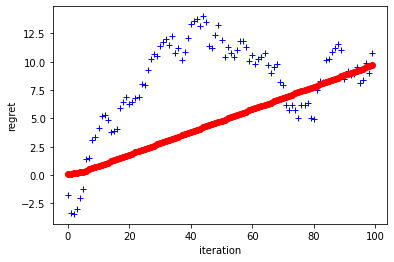

Optimal action: 1


In [0]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
experiment_etc(
    k=2,
    mu=(0.9, 1.0), 
    m=3,
    rounds=200
)

Exploration phase with 3 rounds...
Exploration finished after 3 rounds. Choosing best action...
Best action chosen. Playing... with 94 remaining...


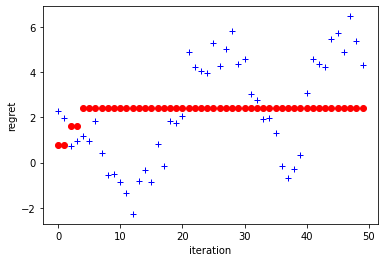

Optimal action: 2


In [0]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
experiment_etc(
    k=2,
    mu=(0.2, 1.0), 
    m=3,
    rounds=100
)

Exploration phase with 4 rounds...
Exploration finished after 4 rounds. Choosing best action...
Best action chosen. Playing... with 980 remaining...


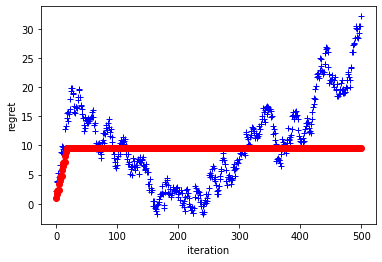

Optimal action: 5


In [0]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
experiment_etc(
    k=5,
    mu=(0.1, 0.3, 0.5, 0.7, 1.0),
    m=4,
    rounds=1000
)

Exploration phase with 30 rounds...
Exploration finished after 30 rounds. Choosing best action...
Best action chosen. Playing... with 8500 remaining...


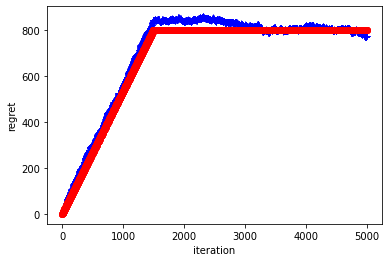

Optimal action: 25


In [0]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?
k = 50
mu = random_sample((50, ))
m = 30
rounds = 10000
experiment_etc(
    k=k,
    mu=mu, 
    m=m,
    rounds=rounds
)

### UCB use-cases

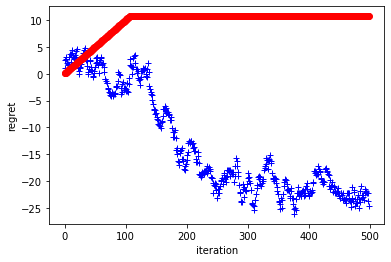

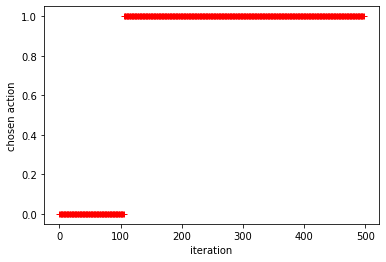

In [0]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
k = 2
mu = (0.9, 1.0)
delta = 0.4
rounds = 1000

experiment_ucb(
    k=k, 
    mu=mu, 
    delta=delta, 
    rounds=rounds
)

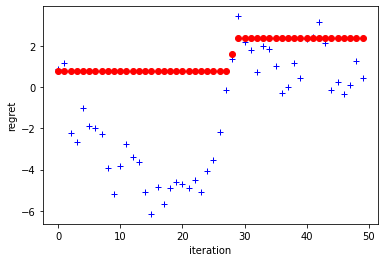

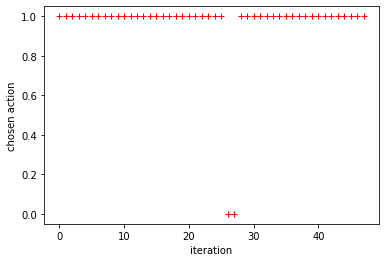

In [0]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta?
k = 2
mu = (0.2, 1.0)
delta = 0.8
rounds = 100

experiment_ucb(
    k=k,
    mu=mu, 
    delta=delta,
    rounds=rounds
)

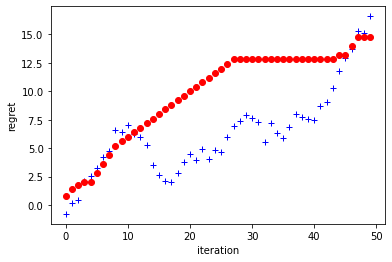

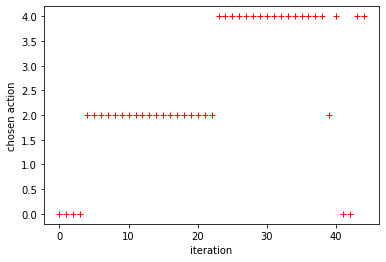

In [0]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta?
k=5
mu=(0.2, 0.4, 0.6, 0.8, 1.0)
delta=0.5 
rounds=100
experiment_ucb(
    k=k,
    mu=mu,
    delta=delta, 
    rounds=rounds
)

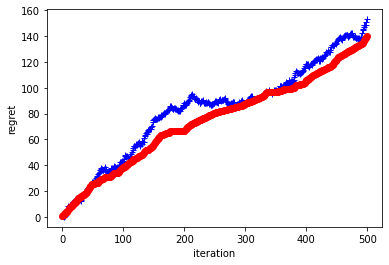

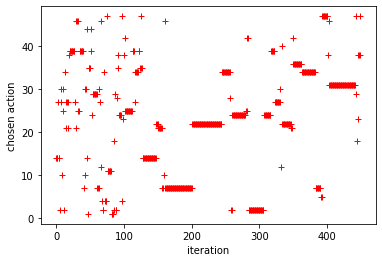

In [0]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta?
experiment_ucb(
    k=50, 
    mu=random_sample((50, )), 
    delta=0.7,
    rounds=1000
)